In [1]:
import torch
from torch import nn

import torchvision
from torchvision.io import read_video

import numpy as np
import pandas as pd 
import os
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
from torch.utils.data import Dataset

class LRWDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

        self.classes = self.df['label'].unique()
        self.class_to_idx = {classname: idx for idx, classname in enumerate(self.classes)}


    def get_mouth_roi(self, path):
        tokens = path.split('/')
        label, split, filename = tokens[-3:]
        filename = filename.split('.')[0]

        roi = np.load(os.path.join('mouth/roi/', label, split, filename+'.npy'))
        return roi, label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        roi, label = self.get_mouth_roi(str(path))
        class_idx = self.class_to_idx[label]

        
        if self.transforms:
            return self.transforms(roi), class_idx

        return roi, class_idx

In [4]:
from torchvision.transforms import v2

data_transform = v2.Compose([
    v2.Normalize([0.0], [255.0]),
    # v2.Normalize(mean=[0.421], std=[0.165])
])

# Data Augmentation
train_transform = v2.Compose([
    v2.Normalize([0.0], [255.0]),
    v2.RandomHorizontalFlip(p=1),
    # v2.Normalize(mean=[0.421], std=[0.165])
])

In [5]:
import pandas as pd

train_df = pd.read_pickle("dataframe/train_df_complete.pkl")
test_df = pd.read_pickle("dataframe/test_df_complete.pkl")
val_df = pd.read_pickle("dataframe/val_df_complete.pkl")

labels = ['ALLEGATIONS', 'BUSINESSES', 'CONSERVATIVE', 'DIFFERENCE', 'EVERYTHING', 'FINANCIAL', 'GOVERNMENT', 'HAPPENING','IMMIGRATION', 'JUSTICE', 'KILLED', 'MANCHESTER', 'SIGNIFICANT', 'VIOLENCE', 'YESTERDAY']
print(labels)
train_df_2 = train_df[train_df['label'].isin(labels)].copy()
test_df_2 = test_df[test_df['label'].isin(labels)]
val_df_2 = val_df[val_df['label'].isin(labels)]

['ALLEGATIONS', 'BUSINESSES', 'CONSERVATIVE', 'DIFFERENCE', 'EVERYTHING', 'FINANCIAL', 'GOVERNMENT', 'HAPPENING', 'IMMIGRATION', 'JUSTICE', 'KILLED', 'MANCHESTER', 'SIGNIFICANT', 'VIOLENCE', 'YESTERDAY']


In [6]:
train_data = LRWDataset(df=train_df_2, transforms=data_transform)
test_data = LRWDataset(df=test_df_2, transforms=data_transform)
val_data = LRWDataset(df=val_df_2, transforms=data_transform)

In [7]:
custom_df = pd.read_pickle('dataframe/custom.pkl')
custom_test_df = pd.read_pickle('dataframe/custom_test.pkl')

In [8]:
from torch.utils.data import Dataset

class LRWDatasetCustom(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

        self.classes = self.df['label'].unique()
        self.class_to_idx = {classname: idx for idx, classname in enumerate(self.classes)}


    def get_mouth_roi(self, path):
        tokens = path.split('/')
        label, filename = tokens[-2:]
        filename = filename.split('.')[0]
        split = 'train'
        roi = np.load(os.path.join('mouth/roi/', label, split, filename+'.npy'))
        return roi, label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        # duration = self.df.iloc[idx]['duration']
        roi, label = self.get_mouth_roi(str(path))
        class_idx = self.class_to_idx[label]

        # roi = self._apply_variable_length_aug(roi, duration)
        
        if self.transforms:
            return self.transforms(roi), class_idx

        return roi, class_idx

In [9]:
from torch.utils.data import Dataset

class LRWDatasetCustomTest(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

        self.classes = self.df['label'].unique()
        self.class_to_idx = {classname: idx for idx, classname in enumerate(self.classes)}


    def get_mouth_roi(self, path):
        tokens = path.split('/')
        label, filename = tokens[-2:]
        filename = filename.split('.')[0]
        split = 'test'
        roi = np.load(os.path.join('mouth/roi/', label, split, filename+'.npy'))
        return roi, label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['path']
        # duration = self.df.iloc[idx]['duration']
        roi, label = self.get_mouth_roi(str(path))
        class_idx = self.class_to_idx[label]

        # roi = self._apply_variable_length_aug(roi, duration)
        
        if self.transforms:
            return self.transforms(roi), class_idx

        return roi, class_idx

In [10]:
custom_data = LRWDatasetCustom(df=custom_df, transforms=data_transform)
custom_data_flipped = LRWDatasetCustom(df=custom_df, transforms=train_transform)

In [11]:
custom_data_test = LRWDatasetCustomTest(df=custom_test_df, transforms=data_transform)
custom_data_test_flipped = LRWDatasetCustomTest(df=custom_test_df, transforms=train_transform)

In [12]:
from torch.utils.data import ConcatDataset

concat_dataset = ConcatDataset([train_data, custom_data, custom_data_flipped])
custom_test_concat = ConcatDataset([custom_data_test, custom_data_test_flipped])
custom_concat = ConcatDataset([custom_data, custom_data_flipped])

In [13]:
concat_val_data = ConcatDataset([val_data, custom_data_test])

In [14]:
import torch

def collate_fn(batch):
    # Sort batch by sequence length (descending order) to use with pad_sequence
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    
    # Separate sequences and labels
    sequences, labels = zip(*batch)
    
    # Get sequence lengths
    lengths = [len(seq) for seq in sequences]
    
    # Convert sequences to tensors
    sequences_tensor = [torch.tensor(seq) for seq in sequences]
    
    # Pad sequences to the same length
    padded_sequences = torch.nn.utils.rnn.pad_sequence(sequences_tensor, batch_first=True, padding_value=0)
    
    # Convert labels to tensor
    labels_tensor = torch.tensor(labels)
    
    return padded_sequences, labels_tensor, lengths


In [15]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 5
NUM_WORKERS = 1

train_dataloader = DataLoader(dataset=concat_dataset,
                              collate_fn=collate_fn,
                             num_workers=NUM_WORKERS,
                             shuffle=True,
                             pin_memory=True,
                             batch_size=BATCH_SIZE)

test_dataloader = DataLoader(dataset=test_data,
                            num_workers=NUM_WORKERS,
                            shuffle=False,
                            batch_size=BATCH_SIZE,collate_fn=collate_fn)


val_dataloader = DataLoader(dataset=val_data,
                            num_workers=NUM_WORKERS,
                            shuffle=False,
                            batch_size=BATCH_SIZE,
                            pin_memory=True,
                           collate_fn=collate_fn)

In [16]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 5
NUM_WORKERS = 1

custom_test_dataloader = DataLoader(dataset=custom_test_concat,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             pin_memory=True,
                             batch_size=BATCH_SIZE,
                              collate_fn=collate_fn
                                   )

custom_dataloader = DataLoader(dataset=custom_data,
                             num_workers=NUM_WORKERS,
                             shuffle=True,
                             pin_memory=True,
                             batch_size=BATCH_SIZE,
                              collate_fn=collate_fn
                                   )

### Train Functions

#### Multi Cells

In [9]:
import torch

from typing import Tuple, Dict, List
from tqdm.notebook import tqdm

def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              epoch: int = None,
               scheduler: torch.optim.Optimizer = None,
              device: torch.device='cpu') -> Tuple[float, float, List[float], List[float]]:

    """This function defines the training step for a model.
    
    Args:
        model (torch.nn.Module): The model that is to be trained.
        dataloader (torch.utils.data.DataLoader): The training dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the train loss and accuracy for an epoch.

        Example Usage: train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device)
    """

    model.train()
    train_loss = 0
    train_acc = 0
    batch_lr = []
    batch_train_loss = []
    batch_train_acc = []

    iters = len(dataloader)
    
    for batch,(X,y) in enumerate(tqdm(dataloader, desc="Train")):
        X,y = X.to(device), y.to(device)
        X = X.unsqueeze(dim=1)
        X = X.type(torch.float32)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        # Forward pass
        y_logits = model(X)

        # Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        batch_train_loss.append(loss.item())

        # Back Propagation
        loss.backward()

        # Optimizer Step
        optimizer.step()

        if scheduler:
            batch_lr.append(scheduler.get_last_lr())
            # scheduler.step(epoch + batch / iters)
            scheduler.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        acc = (y_pred_class == y).sum().item()/len(y_logits)
        train_acc += acc
        batch_train_acc.append(acc)

    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc, batch_lr, batch_train_loss, batch_train_acc

In [10]:
def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device='cpu') -> Tuple[float, float, List[float], List[float]]:
    """This function defines the validation step for a model.
    
    Args:
        model (torch.nn.Module): The model that is to be validated.
        dataloader (torch.utils.data.DataLoader): The validation dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the validation loss and accuracy for an epoch.

        Example Usage: val_loss, val_acc = val_step(model=model, dataloader=val_dataloader, loss_fn=loss_fn, device=device)
    """
    model.eval()
    val_loss = 0
    val_acc = 0
    batch_val_loss = []
    batch_val_acc = []

    with torch.inference_mode():
        for batch,(X,y) in enumerate(tqdm(dataloader, desc="Val")):
            X,y = X.to(device), y.to(device)
            X = X.unsqueeze(dim=1)
            X = X.type(torch.float32)
            
            # Forward pass
            y_logits = model(X)
    
            # Calculate loss
            loss = loss_fn(y_logits, y)
            val_loss += loss.item()
            batch_val_loss.append(loss.item())

            # Calculate and accumulate accuracy
            y_labels = y_logits.argmax(dim=1)
            acc = ((y_labels == y).sum().item()/len(y_labels))
            val_acc += acc
            batch_val_acc.append(acc)

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)
    return val_loss, val_acc, batch_val_loss, batch_val_acc

In [11]:
def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         val_dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         epoch_lr_scheduler: torch.optim.Optimizer = None,
         epochs: int = 32,
          batch_lr_scheduler: torch.optim.Optimizer = None,
          batch_size: int = 24,
         device: torch.device = 'cpu') -> Dict[str, List[float]]:
    """This function defines the training functionality of the model.
    
    Args:
        model (torch.nn.Module): The model that is to be trained.
        train_dataloader (torch.utils.data.DataLoader): The training dataloader
        val_dataloader (torch.utils.data.DataLoader): The validation dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        epochs (int): Number of epochs. Default=32
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the train loss and accuracy for an epoch.

        Example Usage: train_loss, train_acc, val_loss, val_acc = train(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_fn=loss_fn,
                                                                        optimizer=optimizer, epochs=32, device=device)
    """
    CHECKPOINT_PATH = 'checkpoint/'
    
    model_results = {'model_name': model.__class__.__name__,
                    'train_loss': [],
                    'train_acc': [],
                    'val_loss': [],
                    'val_acc': [],
                     'batch_lr': [],
                    'batch_size': batch_size,
                    'train_dataset_len': len(train_dataloader.dataset),
                    'val_dataset_len': len(val_dataloader.dataset)}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, batch_lr, batch_train_loss, batch_train_acc =  train_step(model=model,
                                                                    dataloader=train_dataloader,
                                                                    loss_fn=loss_fn,
                                                                    optimizer=optimizer,
                                                                    scheduler=batch_lr_scheduler,
                                                                    epoch=epoch,
                                                                    device=device)
        
        val_loss, val_acc, batch_val_loss, batch_val_acc = val_step(model=model,
                                                                   dataloader=val_dataloader,
                                                                   loss_fn=loss_fn,
                                                                   device=device)
        if epoch_lr_scheduler is not None:
            epoch_lr_scheduler.step()
        
        model_results['train_loss'].extend(batch_train_loss)
        model_results['train_acc'].extend(batch_train_acc)
        model_results['val_loss'].extend(batch_val_loss)
        model_results['val_acc'].extend(batch_val_acc)
        model_results['batch_lr'].extend(batch_lr)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%")

        if (epoch+1) % 5 == 0:
            filename = f'{model.__class__.__name__}_{epoch+1}.pth'
            save_path = CHECKPOINT_PATH + filename
            
            torch.save(obj=model.state_dict(), f=save_path)
    model_results['optimizer_params'] = optimizer.state_dict()
    np.savez(file=f"results/{model.__class__.__name__}.npz", arr=model_results)
    return model_results

#### Compiled

In [17]:
import torch

from typing import Tuple, Dict, List
from tqdm.notebook import tqdm

def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              epoch: int = None,
               scheduler: torch.optim.lr_scheduler._LRScheduler = None,
              device: torch.device='cpu') -> Tuple[float, float, List[float], List[float]]:

    model.train()
    train_loss = 0
    train_acc = 0
    batch_lr = []
    batch_train_loss = []
    batch_train_acc = []

    iters = len(dataloader)
    
    for batch,(X,y,lengths) in enumerate(tqdm(dataloader, desc="Train")):
        X,y = X.to(device), y.to(device)
        X = X.unsqueeze(dim=1)
        X = X.type(torch.float32)
        
        # Optimizer zero grad
        optimizer.zero_grad()
        # Forward pass
        y_logits = model(X, lengths)

        # Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        batch_train_loss.append(loss.item())

        # Back Propagation
        loss.backward()

        # Optimizer Step
        optimizer.step()

        if scheduler:
            batch_lr.append(scheduler.get_last_lr()[0])
            # scheduler.step(epoch + batch / iters)
            scheduler.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        acc = (y_pred_class == y).sum().item()/len(y_logits)
        train_acc += acc
        batch_train_acc.append(acc)

    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc, batch_lr, batch_train_loss, batch_train_acc


def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device='cpu') -> Tuple[float, float, List[float], List[float]]:
    """This function defines the validation step for a model.
    
    Args:
        model (torch.nn.Module): The model that is to be validated.
        dataloader (torch.utils.data.DataLoader): The validation dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the validation loss and accuracy for an epoch.

        Example Usage: val_loss, val_acc = val_step(model=model, dataloader=val_dataloader, loss_fn=loss_fn, device=device)
    """
    model.eval()
    val_loss = 0
    val_acc = 0
    batch_val_loss = []
    batch_val_acc = []

    with torch.inference_mode():
        for batch,(X,y,lengths) in enumerate(tqdm(dataloader, desc="Val")):
            X,y = X.to(device), y.to(device)
            X = X.unsqueeze(dim=1)
            X = X.type(torch.float32)
            
            # Forward pass
            y_logits = model(X, lengths)
    
            # Calculate loss
            loss = loss_fn(y_logits, y)
            val_loss += loss.item()
            batch_val_loss.append(loss.item())

            # Calculate and accumulate accuracy
            y_labels = y_logits.argmax(dim=1)
            acc = ((y_labels == y).sum().item()/len(y_labels))
            val_acc += acc
            batch_val_acc.append(acc)

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)
    return val_loss, val_acc, batch_val_loss, batch_val_acc


def train(model: torch.nn.Module,
         train_dataloader: torch.utils.data.DataLoader,
         val_dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         epoch_lr_scheduler: torch.optim.lr_scheduler._LRScheduler = None,
         epochs: int = 32,
          batch_lr_scheduler: torch.optim.lr_scheduler._LRScheduler = None,
          batch_size: int = 24,
         device: torch.device = 'cpu') -> Dict[str, List[float]]:
    """This function defines the training functionality of the model.
    
    Args:
        model (torch.nn.Module): The model that is to be trained.
        train_dataloader (torch.utils.data.DataLoader): The training dataloader
        val_dataloader (torch.utils.data.DataLoader): The validation dataloader
        loss_fn (torch.nn.Module): Loss function to evaluate the model
        optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
        epochs (int): Number of epochs. Default=32
        device (torch.device): The device used to train the model. Default='cpu'

    Returns:
        A tuple consisting the train loss and accuracy for an epoch.

        Example Usage: train_loss, train_acc, val_loss, val_acc = train(model=model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_fn=loss_fn,
                                                                        optimizer=optimizer, epochs=32, device=device)
    """
    CHECKPOINT_PATH = 'checkpoint/'
    
    model_results = {'model_name': model.__class__.__name__,
                    'train_loss_batch': [],
                    'train_acc_batch': [],
                    'val_loss_batch': [],
                    'val_acc_batch': [],
                     'train_loss_epoch': [],
                     'val_loss_epoch': [],
                     'train_acc_epoch': [],
                     'val_acc_epoch': [],
                     'batch_lr': [],
                     'max_epoch': epochs,
                    'batch_size': batch_size,
                    'train_dataset_len': len(train_dataloader.dataset),
                    'val_dataset_len': len(val_dataloader.dataset)}
    
    for epoch in tqdm(range(epochs)):
        if epoch_lr_scheduler is not None:
            lr = optimizer.param_groups[0]['lr']
            
        train_loss, train_acc, batch_lr, batch_train_loss, batch_train_acc =  train_step(model=model,
                                                                    dataloader=train_dataloader,
                                                                    loss_fn=loss_fn,
                                                                    optimizer=optimizer,
                                                                    scheduler=batch_lr_scheduler,
                                                                    epoch=epoch,
                                                                    device=device)
        
        val_loss, val_acc, batch_val_loss, batch_val_acc = val_step(model=model,
                                                                   dataloader=val_dataloader,
                                                                   loss_fn=loss_fn,
                                                                   device=device)
        if epoch_lr_scheduler is not None:
            optimizer.param_groups[0]['lr'] = lr
            epoch_lr_scheduler.step()
            if batch_lr_scheduler is not None:
                batch_lr_scheduler.base_lrs = epoch_lr_scheduler._last_lr
        
        model_results['train_loss_batch'].extend(batch_train_loss)
        model_results['train_acc_batch'].extend(batch_train_acc)
        model_results['val_loss_batch'].extend(batch_val_loss)
        model_results['val_acc_batch'].extend(batch_val_acc)
        model_results['batch_lr'].extend(batch_lr)

        model_results['train_loss_epoch'].append(train_loss)
        model_results['train_acc_epoch'].append(train_acc)
        model_results['val_loss_epoch'].append(val_loss)
        model_results['val_acc_epoch'].append(val_acc)
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc*100:.2f}% | Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%")

        if (epoch+1) % 5 == 0:
            filename = f'{model.__class__.__name__}_{epoch+1}_custom.pth'
            save_path = CHECKPOINT_PATH + filename
            
            torch.save(obj=model.state_dict(), f=save_path)
    model_results['optimizer_params'] = optimizer.state_dict()['param_groups'][0]
    np.savez(file=f"results/{model.__class__.__name__}_custom.npz", arr=model_results)
    return model_results

## BaseLine Lipnet Model

In [17]:
class STCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv_block = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.batch_norm = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout3d(p=0.5)
        self.max_pool = nn.MaxPool3d(kernel_size=(1,2,2), stride=(1,2,2))

    def forward(self, x):
        return self.max_pool(self.dropout(self.relu(self.batch_norm(self.conv_block(x)))))


class BiGRU(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        self.gru = nn.GRU(input_size=input_size, hidden_size=output_size, batch_first=True, bidirectional=True, num_layers=2)

    def forward(self, x):
        batch_size, frames, channel, h, w = x.shape
        x = x.reshape(batch_size, frames, channel*h*w)
        return self.gru(x)


class LipNet(nn.Module):
    def __init__(self, in_channels, output_size):
        super().__init__()

        self.stcnn_1 = STCNN(in_channels=in_channels, out_channels=32, kernel_size=(3,5,5), stride=(1,2,2), padding=(1,2,2))
        self.stcnn_2 = STCNN(in_channels=32, out_channels=64, kernel_size=(3,5,5), stride=(1,1,1), padding=(1,2,2))
        self.stcnn_3 = STCNN(in_channels=64, out_channels=96, kernel_size=(3,3,3), stride=(1,1,1), padding=(1,1,1))

        self.gru_1 = BiGRU(input_size=96*6*6, output_size=256)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=2*256, out_features=output_size)

    def forward(self, x):
        x = self.stcnn_1(x)
        x = self.stcnn_2(x)
        x = self.stcnn_3(x)

        x = x.permute(0,2,1,3,4)
        x,_ = self.gru_1(x)
        x = torch.cat((x[:, -1, :256], x[:, 0, 256:]), dim=1)
        x = self.flatten(x)
        x = self.linear(x)
        return x



In [18]:
lipnet_model = LipNet(in_channels=1, output_size=15).to(device)

In [16]:
from torchinfo import summary

summary(lipnet_model, input_size=[32,1,29,96,96], col_names=['input_size', 'kernel_size','output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Kernel Shape              Output Shape              Param #
LipNet                                   [32, 1, 29, 96, 96]       --                        [32, 15]                  --
├─STCNN: 1-1                             [32, 1, 29, 96, 96]       --                        [32, 32, 29, 24, 24]      --
│    └─Conv3d: 2-1                       [32, 1, 29, 96, 96]       [3, 5, 5]                 [32, 32, 29, 48, 48]      2,400
│    └─BatchNorm3d: 2-2                  [32, 32, 29, 48, 48]      --                        [32, 32, 29, 48, 48]      64
│    └─ReLU: 2-3                         [32, 32, 29, 48, 48]      --                        [32, 32, 29, 48, 48]      --
│    └─Dropout3d: 2-4                    [32, 32, 29, 48, 48]      --                        [32, 32, 29, 48, 48]      --
│    └─MaxPool3d: 2-5                    [32, 32, 29, 48, 48]      [1, 2, 2]                 [32, 32, 29, 24, 24]      --
├─STCNN: 1-2    

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=lipnet_model.parameters(), lr=0.001)

In [23]:
lipnet_model_results = train(model=lipnet_model,
                             train_dataloader=train_dataloader,
                             val_dataloader=val_dataloader,
                             loss_fn=loss_fn,
                             optimizer=optimizer,
                             device=device,
                             epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/606 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.19 | Train Acc: 59.96% | Val Loss: 1.09 | Val Acc: 64.19%


Train:   0%|          | 0/606 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 1.07 | Train Acc: 64.69% | Val Loss: 1.13 | Val Acc: 61.59%


Train:   0%|          | 0/606 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 0.98 | Train Acc: 67.31% | Val Loss: 1.03 | Val Acc: 66.02%


Train:   0%|          | 0/606 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 0.92 | Train Acc: 69.54% | Val Loss: 0.89 | Val Acc: 70.18%


Train:   0%|          | 0/606 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 0.89 | Train Acc: 70.24% | Val Loss: 0.88 | Val Acc: 70.44%


Train:   0%|          | 0/606 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 0.86 | Train Acc: 71.36% | Val Loss: 0.87 | Val Acc: 71.48%


Train:   0%|          | 0/606 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 0.80 | Train Acc: 73.47% | Val Loss: 0.87 | Val Acc: 72.79%


Train:   0%|          | 0/606 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 0.77 | Train Acc: 74.42% | Val Loss: 0.86 | Val Acc: 71.09%


Train:   0%|          | 0/606 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 0.74 | Train Acc: 75.19% | Val Loss: 0.74 | Val Acc: 73.96%


Train:   0%|          | 0/606 [00:00<?, ?it/s]

Val:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 0.76 | Train Acc: 74.99% | Val Loss: 0.81 | Val Acc: 75.39%


In [28]:
lipnet_model.load_state_dict(torch.load(f='checkpoint/lr_0.00001_wd_0.0001/LipNet_20.pth'))

loss, acc = val_step(model=lipnet_model, dataloader=test_dataloader, device=device, loss_fn=loss_fn)

print(f'Test Loss: {loss:.4f} | Test Acc: {acc*100:.2f}%')

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 0.4245 | Test Acc: 86.67%


In [27]:
import matplotlib.pyplot as plt

def plot_loss_curves(results, epochs=20):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title('Accuracy')
    plt.plot(range(epochs), results['train_acc'], label='Train')
    plt.plot(range(epochs), results['val_acc'], label='Val')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title('Loss')
    plt.plot(range(epochs), results['train_loss'], label='Train')
    plt.plot(range(epochs), results['val_loss'], label='Val')
    plt.xlabel('Epochs')
    plt.grid(True)
    plt.legend()
    
    plt.show()

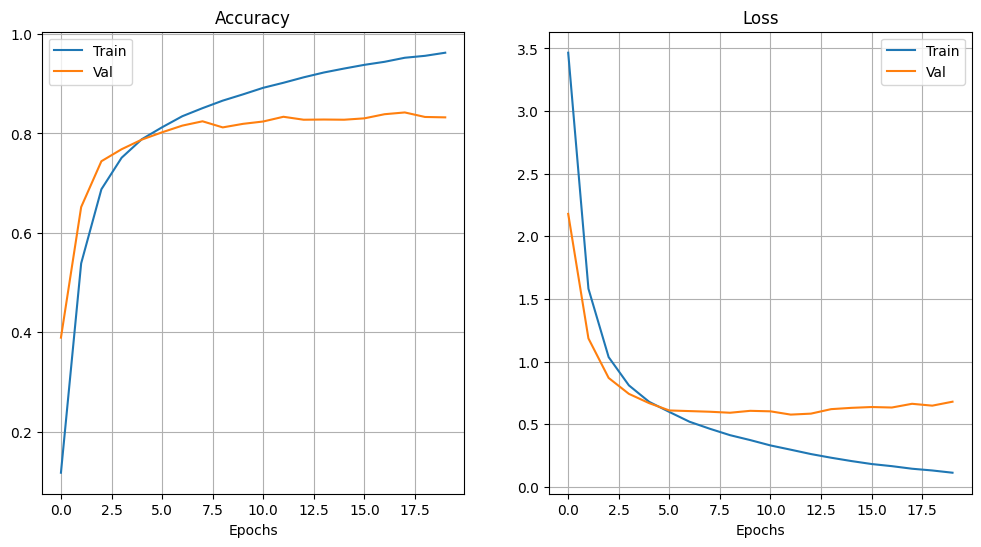

In [18]:
plot_loss_curves(lipnet_model_results)

## LipNet

In [12]:
lipnet_data_aug_model = LipNet(in_channels=1, output_size=50).to(device)

In [35]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(params=lipnet_data_aug_model.parameters(), lr=0.0001, weight_decay=0.0001)

In [36]:
lipnet_data_aug_results = train(model=lipnet_data_aug_model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=device, epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.40 | Train Acc: 87.14% | Val Loss: 0.52 | Val Acc: 84.22%


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 0.37 | Train Acc: 87.93% | Val Loss: 0.52 | Val Acc: 84.77%


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 2 | Train Loss: 0.34 | Train Acc: 88.61% | Val Loss: 0.49 | Val Acc: 85.32%


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 3 | Train Loss: 0.31 | Train Acc: 89.76% | Val Loss: 0.50 | Val Acc: 84.93%


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 4 | Train Loss: 0.29 | Train Acc: 90.73% | Val Loss: 0.52 | Val Acc: 84.41%


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 5 | Train Loss: 0.26 | Train Acc: 91.68% | Val Loss: 0.50 | Val Acc: 85.96%


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 6 | Train Loss: 0.23 | Train Acc: 92.44% | Val Loss: 0.49 | Val Acc: 85.96%


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 7 | Train Loss: 0.20 | Train Acc: 93.24% | Val Loss: 0.52 | Val Acc: 84.93%


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 8 | Train Loss: 0.18 | Train Acc: 93.85% | Val Loss: 0.52 | Val Acc: 85.52%


Train:   0%|          | 0/1531 [00:00<?, ?it/s]

Val:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 9 | Train Loss: 0.16 | Train Acc: 94.58% | Val Loss: 0.51 | Val Acc: 84.97%


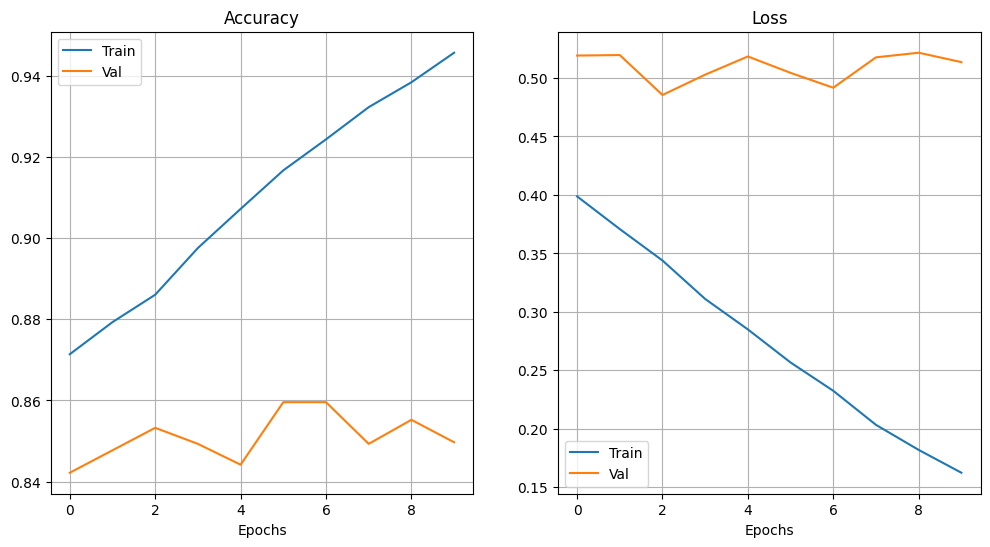

In [37]:
plot_loss_curves(lipnet_data_aug_results, epochs=10)

## LipNet with LSTM

In [12]:
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

In [13]:
class STCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv_block = nn.Conv3d(in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=kernel_size,
                                    stride=stride, 
                                    padding=padding,
                                    bias=False)
        self.batch_norm = nn.BatchNorm3d(out_channels, track_running_stats=False)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout3d(p=0.2)
        self.max_pool = nn.MaxPool3d(kernel_size=(1,2,2),
                                     stride=(1,2,2))

    def forward(self, x):
        return self.max_pool(self.dropout(self.relu(self.batch_norm(self.conv_block(x)))))


class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          bidirectional=True,
                          num_layers=4,
                          dropout=0.3)
    
    def forward(self, x):
        return self.gru(x)


class LipNet_GRU(nn.Module):
    def __init__(self, in_channels, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.stcnn_1 = STCNN(in_channels=in_channels,
                             out_channels=32,
                             kernel_size=(3,5,5),
                             stride=(1,2,2),
                             padding=(1,2,2))
        self.stcnn_2 = STCNN(in_channels=32,
                             out_channels=64,
                             kernel_size=(3,5,5),
                             stride=(1,1,1),
                             padding=(1,2,2))
        self.stcnn_3 = STCNN(in_channels=64,
                             out_channels=96,
                             kernel_size=(3,3,3),
                             stride=(1,1,1),
                             padding=(1,1,1))

        self.gru_1 = BiGRU(input_size=96*6*6,
                           hidden_size=hidden_size)

        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2*hidden_size,
                      out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,
                      out_features=output_size)
        )

    def forward(self, x, lengths):
        x = self.stcnn_1(x)
        x = self.stcnn_2(x)
        x = self.stcnn_3(x)
        x = x.permute(0,2,1,3,4)
        x = x.reshape(x.size(0), x.size(1), -1) 
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        x,_ = self.gru_1(x)
        x, _ = pad_packed_sequence(x, batch_first=True)
        # print(x.shape)
        x_combined = torch.cat((x[:, -1, :self.hidden_size], x[:, 0, self.hidden_size:]), dim=1)
        x = self.classifier(x_combined)
        return x

        # return self.linear(self.flatten(self.lstm_1(self.stcnn_3(self.stcnn_2(self.stcnn_1(x))).permute(0,2,1,3,4))[0]))



In [14]:
lipnet_lstm_model = LipNet_GRU(in_channels=1,
                               output_size=50,
                               hidden_size=824).to('cuda')

In [15]:
# lipnet_lstm_model.load_state_dict(torch.load('checkpoint/lstm_0.0001_0.001_0-30/LipNet_LSTM_15.pth'))

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=lipnet_lstm_model.parameters(),
                             lr=0.0001,
                             weight_decay=1e-3)

In [17]:
from torch.optim.lr_scheduler import ExponentialLR, StepLR, ReduceLROnPlateau

scheduler = None
scheduler = ExponentialLR(optimizer=optimizer,
                          gamma=0.8,
                          verbose=True)
# scheduler = StepLR(optimizer, step_size=5, gamma=0.5, verbose=True)

scheduler_2 = ReduceLROnPlateau(optimizer, 'min')

Adjusting learning rate of group 0 to 1.0000e-04.


In [18]:
lipnet_model_results = train(model=lipnet_lstm_model,
                             train_dataloader=train_dataloader,
                             val_dataloader=val_dataloader,
                             loss_fn=loss_fn, optimizer=optimizer,
                             scheduler=scheduler,
                             device=device,
                             epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/2041 [00:00<?, ?it/s]

Val:   0%|          | 0/105 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 8.0000e-05.
Epoch: 0 | Train Loss: 3.90 | Train Acc: 2.84% | Val Loss: 3.88 | Val Acc: 3.57%


Train:   0%|          | 0/2041 [00:00<?, ?it/s]

Val:   0%|          | 0/105 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.4000e-05.
Epoch: 1 | Train Loss: 3.80 | Train Acc: 4.48% | Val Loss: 3.18 | Val Acc: 12.66%


Train:   0%|          | 0/2041 [00:00<?, ?it/s]

Val:   0%|          | 0/105 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.1200e-05.
Epoch: 2 | Train Loss: 2.40 | Train Acc: 29.86% | Val Loss: 1.80 | Val Acc: 45.48%


Train:   0%|          | 0/2041 [00:00<?, ?it/s]

Val:   0%|          | 0/105 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.0960e-05.
Epoch: 3 | Train Loss: 1.57 | Train Acc: 52.32% | Val Loss: 1.35 | Val Acc: 57.98%


Train:   0%|          | 0/2041 [00:00<?, ?it/s]

Val:   0%|          | 0/105 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.2768e-05.
Epoch: 4 | Train Loss: 1.23 | Train Acc: 62.23% | Val Loss: 1.14 | Val Acc: 64.88%


Train:   0%|          | 0/2041 [00:00<?, ?it/s]

Val:   0%|          | 0/105 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.6214e-05.
Epoch: 5 | Train Loss: 1.00 | Train Acc: 69.24% | Val Loss: 0.94 | Val Acc: 71.07%


Train:   0%|          | 0/2041 [00:00<?, ?it/s]

Val:   0%|          | 0/105 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0972e-05.
Epoch: 6 | Train Loss: 0.83 | Train Acc: 73.93% | Val Loss: 0.81 | Val Acc: 74.44%


Train:   0%|          | 0/2041 [00:00<?, ?it/s]

Val:   0%|          | 0/105 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.6777e-05.
Epoch: 7 | Train Loss: 0.72 | Train Acc: 77.34% | Val Loss: 0.74 | Val Acc: 77.26%


Train:   0%|          | 0/2041 [00:00<?, ?it/s]

Val:   0%|          | 0/105 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.3422e-05.
Epoch: 8 | Train Loss: 0.65 | Train Acc: 79.29% | Val Loss: 0.73 | Val Acc: 77.54%


Train:   0%|          | 0/2041 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassF1Score, MulticlassConfusionMatrix

recall = MulticlassRecall(num_classes=10)
precision = MulticlassPrecision(num_classes=10)
f1_score = MulticlassF1Score(num_classes=10)
conf_mat = MulticlassConfusionMatrix(num_classes=10)

In [19]:
target, pred = [],[]

In [20]:
def val_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device='cpu') -> Tuple[float, float]:
    model.eval()
    val_loss = 0
    val_acc = 0

    with torch.inference_mode():
        for batch,(X,y, lengths) in enumerate(tqdm(dataloader, desc="Val")):
            X,y = X.to(device), y.to(device)
            X = X.unsqueeze(dim=1)
            X = X.type(torch.float32)

            target.extend(list(y.cpu().numpy()))
            # Forward pass
            y_logits = model(X, lengths)
    
            # Calculate loss
            loss = loss_fn(y_logits, y)
            val_loss += loss.item()

            # Calculate and accumulate accuracy
            y_labels = y_logits.argmax(dim=1)
            val_acc += ((y_labels == y).sum().item()/len(y_labels))
            pred.extend(y_labels.cpu().numpy())

    val_loss = val_loss/len(dataloader)
    val_acc = val_acc/len(dataloader)
    return val_loss, val_acc

In [21]:
lipnet_lstm_model.load_state_dict(torch.load('checkpoint/LipNet_GRU_15.pth'))

<All keys matched successfully>

In [24]:
val_step(model=lipnet_lstm_model, dataloader=test_dataloader, loss_fn=loss_fn, device='cuda')

Val:   0%|          | 0/16 [00:00<?, ?it/s]

(0.4356676498427987, 0.8609375)

In [25]:
recall(torch.tensor(pred), torch.tensor(target))

tensor(0.8600)

In [26]:
precision(torch.tensor(pred), torch.tensor(target))

tensor(0.8616)

In [27]:
f1_score(torch.tensor(pred), torch.tensor(target))

tensor(0.8590)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

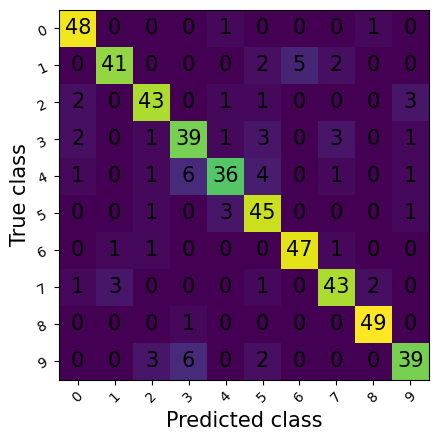

In [28]:
conf_mat.update(torch.tensor(pred), torch.tensor(target))
conf_mat.plot()

In [20]:
train_dataloader_no_shuffle = DataLoader(dataset=train_data,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             pin_memory=True,
                             batch_size=BATCH_SIZE)

## ResNet

#### Train

In [18]:
import math
import torch.nn as nn
import pdb

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def downsample_basic_block( inplanes, outplanes, stride ):
    return  nn.Sequential(
                nn.Conv2d(inplanes, outplanes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outplanes),
            )

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)

        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu2(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=50):
        self.inplanes = 64
        self.downsample_block = downsample_basic_block

        super(ResNet, self).__init__()
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # default init
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                #nn.init.ones_(m.weight)
                #nn.init.zeros_(m.bias)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = self.downsample_block(inplanes = self.inplanes,
                                                 outplanes = planes * block.expansion,
                                                 stride = stride)

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

In [19]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class STCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv_block = nn.Conv3d(in_channels=1,
                                    out_channels=out_channels,
                                    kernel_size=kernel_size,
                                    stride=stride, 
                                    padding=padding,
                                    bias=False)
        self.batch_norm = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool3d(kernel_size=(1,3,3),
                                     stride=(1,2,2),
                                     padding=(0, 1, 1))

    def forward(self, x):
        return self.max_pool(self.relu(self.batch_norm(self.conv_block(x))))


class BiGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          bidirectional=True,
                          num_layers=2)
    
    def forward(self, x):
        self.gru.flatten_parameters()
        return self.gru(x)[0]



class ResNet_GRU(nn.Module):
    def __init__(self, in_channels, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.stcnn_1 = STCNN(in_channels=in_channels,
                             out_channels=64,
                             kernel_size=(5, 7, 7),
                             stride=(1, 2, 2),
                             padding=(2, 3, 3))

        self.gru_1 = BiGRU(input_size=512,
                           hidden_size=hidden_size)

        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2])

        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * hidden_size,
                      out_features=output_size)
        )

        # Freeze all layers except the classifier
        for param in self.parameters():
            param.requires_grad = False
        for param in self.classifier.parameters():
            param.requires_grad = True
        for param in self.gru_1.parameters():
            param.requires_grad = True

    def forward(self, x, lengths):
        b = x.size(0)
        x = self.stcnn_1(x)
        x = x.transpose(1, 2).contiguous()
        x = x.view(-1, 64, x.size(3), x.size(4))
        x = self.resnet(x)
        x = x.view(b, -1, 512)
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        x = self.gru_1(x)
        x, _ = pad_packed_sequence(x, batch_first=True)
        x = torch.cat((x[:, -1, :self.hidden_size], x[:, 0, self.hidden_size:]), dim=1)
        x = self.classifier(x)
        return x

In [20]:
resnet_gru_model = ResNet_GRU(in_channels=1,
                               output_size=15,
                               hidden_size=1024).to('cuda')

In [21]:
resnet_gru_model.load_state_dict(torch.load('checkpoint/custom/ResNet_GRU_10_custom.pth'))

<All keys matched successfully>

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet_gru_model.parameters(),
                             lr=0.0001)

In [41]:
from torch.optim.lr_scheduler import ExponentialLR, StepLR, CosineAnnealingWarmRestarts

scheduler = None
step_scheduler = StepLR(optimizer=optimizer, verbose=True, gamma=0.1, step_size=5)
cosine_scheduler_warm_restarts = CosineAnnealingWarmRestarts(optimizer=optimizer, T_0=10)

Adjusting learning rate of group 0 to 1.0000e-06.


In [42]:
lipnet_model_results = train(model=resnet_gru_model,
                             train_dataloader=custom_dataloader,
                             val_dataloader=custom_test_dataloader,
                             loss_fn=loss_fn, 
                             optimizer=optimizer,
                             batch_lr_scheduler=cosine_scheduler_warm_restarts,
                             epoch_lr_scheduler=step_scheduler,
                             device=device,
                             epochs=10,
                            batch_size=BATCH_SIZE)

  0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/102 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 0 | Train Loss: 0.07 | Train Acc: 98.24% | Val Loss: 1.22 | Val Acc: 68.89%


Train:   0%|          | 0/102 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 1 | Train Loss: 0.04 | Train Acc: 99.22% | Val Loss: 1.27 | Val Acc: 71.11%


Train:   0%|          | 0/102 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 2 | Train Loss: 0.03 | Train Acc: 99.02% | Val Loss: 1.34 | Val Acc: 75.56%


Train:   0%|          | 0/102 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-04.
Epoch: 3 | Train Loss: 0.01 | Train Acc: 99.61% | Val Loss: 1.72 | Val Acc: 66.67%


Train:   0%|          | 0/102 [00:00<?, ?it/s]

Val:   0%|          | 0/18 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.0000e-05.
Epoch: 4 | Train Loss: 0.01 | Train Acc: 100.00% | Val Loss: 1.96 | Val Acc: 62.22%


Train:   0%|          | 0/102 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### Evaluate

In [23]:
from torchmetrics.classification import MulticlassRecall, MulticlassPrecision, MulticlassF1Score, MulticlassConfusionMatrix

recall = MulticlassRecall(num_classes=15)
precision = MulticlassPrecision(num_classes=15)
f1_score = MulticlassF1Score(num_classes=15)

In [24]:
resnet_gru_model.load_state_dict(torch.load('checkpoint/best yer/ResNet_GRU_15_custom_freeze.pth'))

<All keys matched successfully>

In [25]:
target, pred = [],[]

from tqdm.auto import tqdm
def evaluate(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device='cpu'):
    model.eval()
    eval_loss = 0
    eval_acc = 0

    with torch.inference_mode():
        for batch,(X,y,lengths) in enumerate(tqdm(dataloader, desc="Evaluate")):
            X,y = X.to(device), y.to(device)
            X = X.unsqueeze(dim=1)
            X = X.type(torch.float32)

            target.extend(list(y.cpu().numpy()))
            # Forward pass
            y_logits = model(X,lengths)
    
            # Calculate loss
            loss = loss_fn(y_logits, y)
            eval_loss += loss.item()

            # Calculate and accumulate accuracy
            y_labels = y_logits.argmax(dim=1)
            eval_acc += ((y_labels == y).sum().item()/len(y_labels))
            pred.extend(y_labels.cpu().numpy())

    eval_loss = eval_loss/len(dataloader)
    eval_acc = eval_acc/len(dataloader)
    return eval_loss, eval_acc

In [26]:
loss, acc = evaluate(model=resnet_gru_model,
                    dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    device=device)

Evaluate:   0%|          | 0/150 [00:00<?, ?it/s]

In [27]:
model_recall = recall(torch.tensor(pred), torch.tensor(target))
model_precision = precision(torch.tensor(pred), torch.tensor(target))
model_f1 = f1_score(torch.tensor(pred), torch.tensor(target))

In [28]:
print("Metrics: \t| Results")
print("-"*16+'+'+'-'*8)
print(f"Test Loss: \t| {loss: .3f}")
print(f"Test Accuracy: \t| {acc: .3f}")
print(f"Recall: \t| {model_recall: .3f}")
print(f"Precision: \t| {model_precision: .3f}")
print(f"F1-Score: \t| {model_f1: .3f}")

Metrics: 	| Results
----------------+--------
Test Loss: 	|  0.295
Test Accuracy: 	|  0.911
Recall: 	|  0.911
Precision: 	|  0.915
F1-Score: 	|  0.911


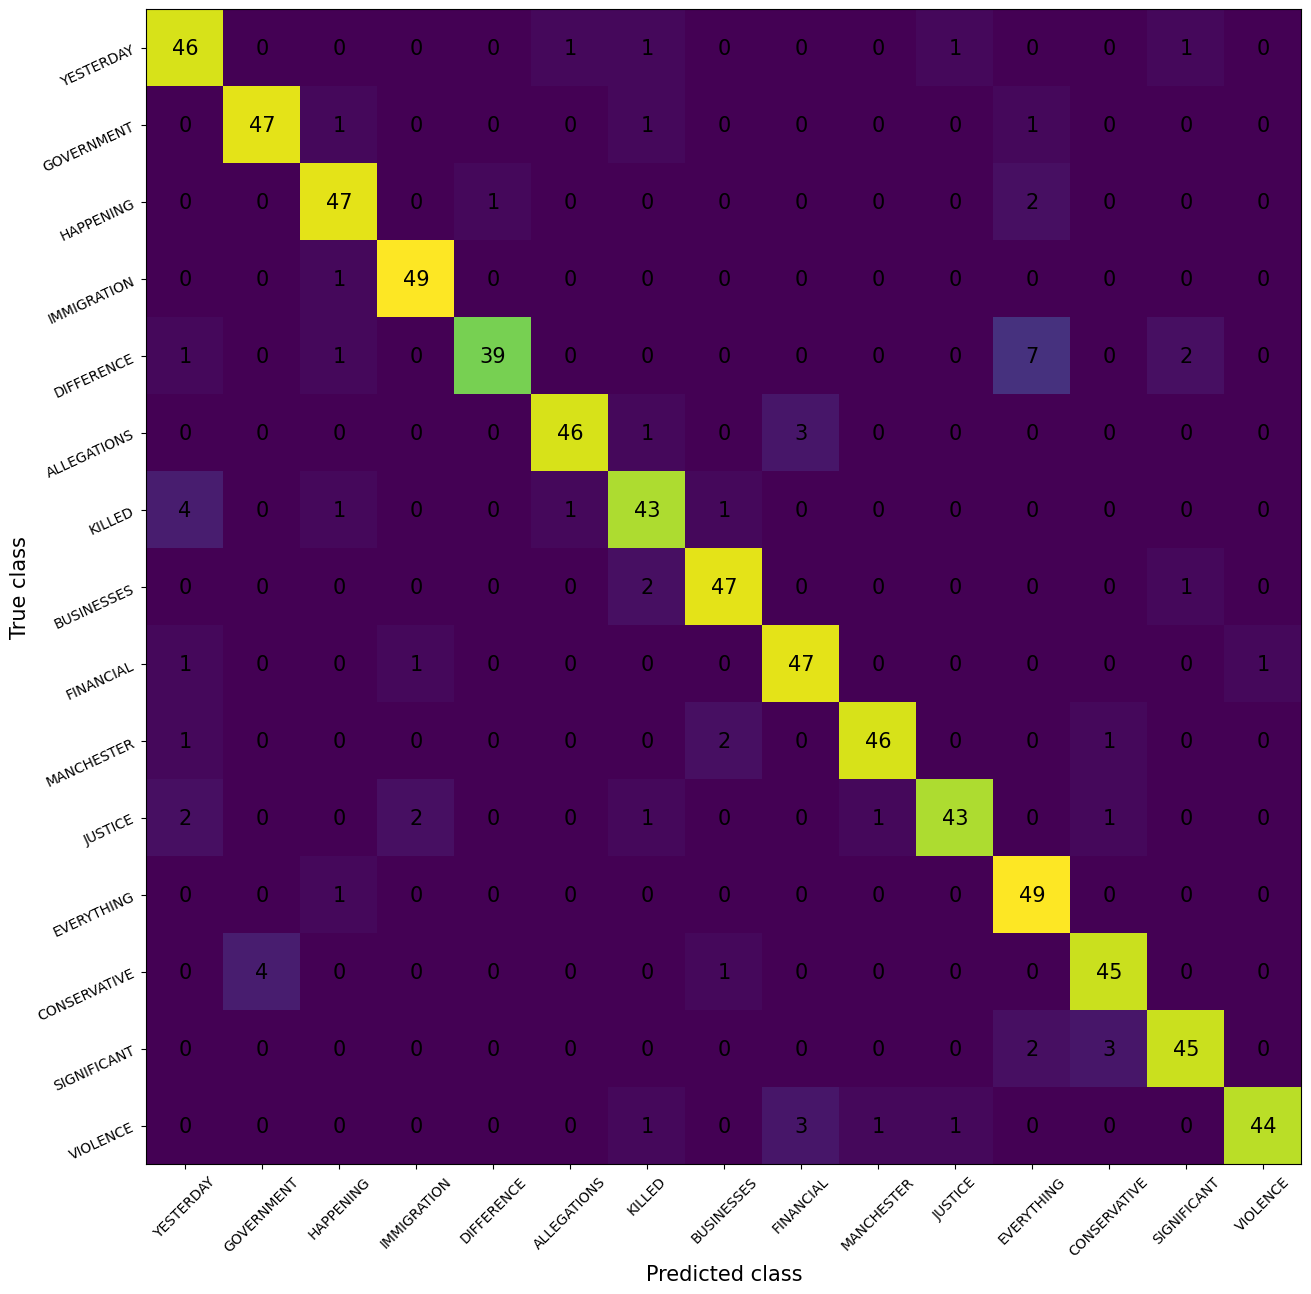

In [29]:
labels = ['YESTERDAY',
 'GOVERNMENT',
 'HAPPENING',
 'IMMIGRATION',
 'DIFFERENCE',
 'ALLEGATIONS',
 'KILLED',
 'BUSINESSES',
 'FINANCIAL',
 'MANCHESTER',
 'JUSTICE',
 'EVERYTHING',
 'CONSERVATIVE',
 'SIGNIFICANT',
 'VIOLENCE']
conf_mat = MulticlassConfusionMatrix(num_classes=15)
conf_mat.update(torch.tensor(pred), torch.tensor(target))
fig, ax = conf_mat.plot(labels=list(labels))

fig.set_figheight(15)
fig.set_figwidth(15)
# fig
fig.savefig('conf_mat_test.png')